In [2]:
import os, re, numpy as np
from PIL import Image
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset
from torchvision import transforms as tvT 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"[Info] Using device: {device}")

class SRDatasetWithPairs(Dataset):
    def __init__(self, lr_dir, hr_dir, train=True, crop_size=128, scale=4, normalize=True):
        super().__init__()
        self.lr_dir = lr_dir
        self.hr_dir = hr_dir
        self.train = train
        self.crop_size = crop_size
        self.scale = int(scale)
        self.normalize = normalize

        if not os.path.isdir(hr_dir):
            raise FileNotFoundError(f"HR dir not found: {hr_dir}")
        if not os.path.isdir(lr_dir):
            raise FileNotFoundError(f"LR dir not found: {lr_dir}")

        valid_exts = ('.png', '.jpg', '.jpeg', '.bmp')

        def naturalsort_key(s):
            return [int(t) if t.isdigit() else t.lower() for t in re.split(r"(\d+)", s)]

        hr_files = [f for f in os.listdir(hr_dir) if f.lower().endswith(valid_exts)]
        hr_files = sorted(hr_files, key=naturalsort_key)

        # case-insensitive set/map for LR names
        lr_all = [f for f in os.listdir(lr_dir) if f.lower().endswith(valid_exts)]
        lr_map = {f.lower(): f for f in lr_all}

        # build HR↔LR pairs
        pairs, missing = [], []
        for hr_name in hr_files:
            base, ext = os.path.splitext(hr_name)
            candidates = (f"{base}x{self.scale}{ext}", f"{base}X{self.scale}{ext}")
            hit = None
            for cand in candidates:
                if cand.lower() in lr_map:
                    hit = lr_map[cand.lower()]
                    break
            if hit is not None:
                pairs.append((hr_name, hit))
            else:
                missing.append(hr_name)

        if not pairs:
            raise RuntimeError(
                f"No HR/LR pairs found for scale={self.scale}.\n"
                f"HR dir: {hr_dir}\nLR dir: {lr_dir}\n"
                f"Expected: HR '0001.png' ↔ LR '0001x{self.scale}.png' (or 'X{self.scale}')"
            )

        self.pairs = pairs
        if missing:
            print(f"[SRDatasetWithPairs] WARNING: {len(missing)} HR images had no LR match. "
                  f"First few: {missing[:5]}")
        print(f"[SRDatasetWithPairs] Matched {len(self.pairs)} pairs (scale={self.scale}, train={self.train}).")

        self.to_tensor = tvT.ToTensor()
        self.norm = tvT.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) if self.normalize else None

    def __len__(self):
        return len(self.pairs)

    def _maybe_norm(self, x):
        return self.norm(x) if self.norm is not None else x

    def __getitem__(self, idx):
        hr_name, lr_name = self.pairs[idx]
        hr = Image.open(os.path.join(self.hr_dir, hr_name)).convert("RGB")
        lr = Image.open(os.path.join(self.lr_dir, lr_name)).convert("RGB")

        hr_t = self.to_tensor(hr)
        lr_t = self.to_tensor(lr) 

        if self.train and self.crop_size is not None:
            ph = pw = int(self.crop_size)
            H, W = hr_t.shape[1:]
            if H >= ph and W >= pw:
                choices_i = np.arange(0, H - ph + 1, self.scale, dtype=int)
                choices_j = np.arange(0, W - pw + 1, self.scale, dtype=int)
                i = int(np.random.choice(choices_i)) if len(choices_i) else 0
                j = int(np.random.choice(choices_j)) if len(choices_j) else 0
                hr_t = hr_t[:, i:i+ph, j:j+pw]
                li, lj = i // self.scale, j // self.scale
                lr_t = lr_t[:, li:li + ph // self.scale, lj:lj + pw // self.scale]
            else:
                i = max(0, (H - ph) // 2); i -= i % self.scale
                j = max(0, (W - pw) // 2); j -= j % self.scale
                i = max(0, min(i, max(0, H - ph)))
                j = max(0, min(j, max(0, W - pw)))
                hr_t = hr_t[:, i:i+ph, j:j+pw]
                li, lj = i // self.scale, j // self.scale
                lr_t = lr_t[:, li:li + ph // self.scale, lj:lj + pw // self.scale]

        # Bicubic-upsample LR to HR canvas
        lr_up = F.interpolate(
            lr_t.unsqueeze(0), size=hr_t.shape[1:], mode='bicubic', align_corners=False
        ).squeeze(0)

        
        hr_t = self._maybe_norm(hr_t)
        lr_t = self._maybe_norm(lr_t)
        lr_up = self._maybe_norm(lr_up)
        
        return lr_t, hr_t, lr_up

[Info] Using device: cuda


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

def timestep_embedding(timesteps, dim):
    half = dim // 2
    freqs = torch.exp(-math.log(10000) * torch.arange(half, dtype=torch.float32) / (half - 1)).to(timesteps.device)
    timesteps = timesteps.float() if timesteps.dtype != torch.float32 else timesteps
    args = timesteps[:, None] * freqs[None, :]
    emb = torch.cat([torch.sin(args), torch.cos(args)], dim=-1)
    return F.pad(emb, (0, 1, 0, 0)) if dim % 2 == 1 else emb

class ResidualDiffusionUNet(nn.Module):
    def __init__(self, in_channels=6, base_channels=64, num_timesteps=1000, predict_x0=False):
        super().__init__()
        self.predict_x0 = predict_x0
        self.in_channels = in_channels
        self.base_channels = base_channels

        time_embed_dim = base_channels * 4
        self.time_emb = nn.Linear(time_embed_dim, time_embed_dim)

        # Down
        self.conv1_1 = nn.Conv2d(in_channels, base_channels, 3, padding=1)
        self.conv1_2 = nn.Conv2d(base_channels, base_channels, 3, padding=1)
        self.down1   = nn.Conv2d(base_channels, base_channels, 4, stride=2, padding=1)

        self.conv2_1 = nn.Conv2d(base_channels, base_channels * 2, 3, padding=1)
        self.conv2_2 = nn.Conv2d(base_channels * 2, base_channels * 2, 3, padding=1)
        self.down2   = nn.Conv2d(base_channels * 2, base_channels * 2, 4, stride=2, padding=1)

        self.conv3_1 = nn.Conv2d(base_channels * 2, base_channels * 2, 3, padding=1)
        self.conv3_2 = nn.Conv2d(base_channels * 2, base_channels * 2, 3, padding=1)

        # Up
        self.up1     = nn.ConvTranspose2d(base_channels * 2, base_channels * 2, 4, stride=2, padding=1)
        self.conv4_1 = nn.Conv2d(base_channels * 4, base_channels * 2, 3, padding=1)
        self.conv4_2 = nn.Conv2d(base_channels * 2, base_channels * 2, 3, padding=1)

        self.up2     = nn.ConvTranspose2d(base_channels * 2, base_channels, 4, stride=2, padding=1)
        self.conv5_1 = nn.Conv2d(base_channels * 2, base_channels, 3, padding=1)
        self.conv5_2 = nn.Conv2d(base_channels, base_channels, 3, padding=1)

        self.final_conv = nn.Conv2d(base_channels, 3, 3, padding=1)

        # Norms
        self.norm1_1 = nn.GroupNorm(8, base_channels)
        self.norm1_2 = nn.GroupNorm(8, base_channels)
        self.norm2_1 = nn.GroupNorm(8, base_channels * 2)
        self.norm2_2 = nn.GroupNorm(8, base_channels * 2)
        self.norm3_1 = nn.GroupNorm(8, base_channels * 2)
        self.norm3_2 = nn.GroupNorm(8, base_channels * 2)
        self.norm4_1 = nn.GroupNorm(8, base_channels * 2)
        self.norm4_2 = nn.GroupNorm(8, base_channels * 2)
        self.norm5_1 = nn.GroupNorm(8, base_channels)
        self.norm5_2 = nn.GroupNorm(8, base_channels)

        # Time-to-channel injections
        self.time_lin1 = nn.Linear(time_embed_dim, base_channels)
        self.time_lin2 = nn.Linear(time_embed_dim, base_channels * 2)
        self.time_lin3 = nn.Linear(time_embed_dim, base_channels * 2)
        self.time_lin4 = nn.Linear(time_embed_dim, base_channels * 2)
        self.time_lin5 = nn.Linear(time_embed_dim, base_channels)

    def forward(self, x_noisy, cond, t):
        x = torch.cat([x_noisy, cond], dim=1)

        t = t if isinstance(t, torch.Tensor) else torch.tensor([t], device=x.device)
        t_embed = F.relu(self.time_emb(timestep_embedding(t, self.base_channels * 4)))

        # Down 1
        h1 = F.relu(self.norm1_1(self.conv1_1(x)))
        h1 = h1 + self.time_lin1(t_embed)[:, :, None, None]
        h1 = F.relu(self.norm1_2(self.conv1_2(h1)))
        h1_skip = h1

        # Down 2
        h2_in = self.down1(h1)
        h2 = F.relu(self.norm2_1(self.conv2_1(h2_in)))
        h2 = h2 + self.time_lin2(t_embed)[:, :, None, None]
        h2 = F.relu(self.norm2_2(self.conv2_2(h2)))
        h2_skip = h2

        # Bottom
        h3_in = self.down2(h2)
        h3 = F.relu(self.norm3_1(self.conv3_1(h3_in)))
        h3 = h3 + self.time_lin3(t_embed)[:, :, None, None]
        h3 = F.relu(self.norm3_2(self.conv3_2(h3)))

        # Up 2 (align spatial dims if odd due to transposed conv)
        u2_in = self.up1(h3)
        if u2_in.shape[2:] != h2_skip.shape[2:]:
            min_h, min_w = min(u2_in.shape[2], h2_skip.shape[2]), min(u2_in.shape[3], h2_skip.shape[3])
            u2_in = u2_in[:, :, :min_h, :min_w]
            h2_skip_cropped = h2_skip[:, :, :min_h, :min_w]
        else:
            h2_skip_cropped = h2_skip

        u2 = torch.cat([u2_in, h2_skip_cropped], dim=1)
        u2 = F.relu(self.norm4_1(self.conv4_1(u2)))
        u2 = u2 + self.time_lin4(t_embed)[:, :, None, None]
        u2 = F.relu(self.norm4_2(self.conv4_2(u2)))

        # Up 1
        u1_in = self.up2(u2)
        if u1_in.shape[2:] != h1_skip.shape[2:]:
            min_h, min_w = min(u1_in.shape[2], h1_skip.shape[2]), min(u1_in.shape[3], h1_skip.shape[3])
            u1_in = u1_in[:, :, :min_h, :min_w]
            h1_skip_cropped = h1_skip[:, :, :min_h, :min_w]
        else:
            h1_skip_cropped = h1_skip

        u1 = torch.cat([u1_in, h1_skip_cropped], dim=1)
        u1 = F.relu(self.norm5_1(self.conv5_1(u1)))
        u1 = u1 + self.time_lin5(t_embed)[:, :, None, None]
        u1 = F.relu(self.norm5_2(self.conv5_2(u1)))

        return self.final_conv(u1)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ResidualDiffusionUNet(in_channels=6, base_channels=64, predict_x0=False).to(device)
print(f"Model params: {sum(p.numel() for p in model.parameters())} parameters")


Model params: 2032835 parameters


In [4]:
# Diffusion schedule setup 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# number of steps
T_STEPS = 30

# linear betas
betas = torch.linspace(1e-4, 2e-2, T_STEPS, device=device, dtype=torch.float32)

# alphas and cumulative product
alphas = 1.0 - betas
alpha_bars = torch.cumprod(alphas, dim=0)

print(f"[Schedule] T_STEPS={T_STEPS}, alpha_bars.shape={alpha_bars.shape}, "
      f"alpha_bar(0)={alpha_bars[0].item():.6f}, "
      f"alpha_bar(last)={alpha_bars[-1].item():.6f}")

# random timestep per sample
def sample_timesteps(batch_size: int) -> torch.Tensor:
    return torch.randint(0, T_STEPS, (batch_size,), device=device)


[Schedule] T_STEPS=30, alpha_bars.shape=torch.Size([30]), alpha_bar(0)=0.999900, alpha_bar(last)=0.738182


In [5]:
# training with checkpoints
import os, math, json, random
import numpy as np
import torch
import torch.optim as optim
import torch.nn.functional as F
from tqdm.auto import tqdm

assert 'model' in globals(), 
assert 'device' in globals(), 
assert 'SRDatasetWithPairs' in globals(),

# hyperparams
EPOCHS        = 300
BATCH_SIZE    = 8
LR            = 1e-4
SCALE         = 4
CROP          = 128
NUM_WORKERS   = 0  
PIN           = torch.cuda.is_available()

# diffusion schedule (alpha_bars)
def _make_cosine_alpha_bars(T: int, s: float = 0.008, device=None):

    t = torch.linspace(0, 1, T + 1, device=device)
    f = torch.cos((t + s) / (1 + s) * math.pi / 2) ** 2
    a_bar_full = f / f[0]              
    return a_bar_full[1:]             

if 'alpha_bars' not in globals():
    T = 50  
    alpha_bars = _make_cosine_alpha_bars(T, device=device)
else:
    alpha_bars = alpha_bars.to(device)

# data 
train_dataset = SRDatasetWithPairs(
    lr_dir="DIV2K_train_LR_bicubic_X4/DIV2K_train_LR_bicubic/X4",
    hr_dir="DIV2K_train_HR/DIV2K_train_HR",
    train=True, crop_size=CROP, scale=SCALE
)
val_dataset = SRDatasetWithPairs(
    lr_dir="DIV2K_valid_LR_bicubic_X4/DIV2K_valid_LR_bicubic/X4",
    hr_dir="DIV2K_valid_HR/DIV2K_valid_HR",
    train=False, crop_size=None, scale=SCALE
)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True,
    num_workers=NUM_WORKERS, pin_memory=PIN, drop_last=True
)

print("First 3 matched pairs:", train_dataset.pairs[:3])
print(f"[Info] Train size: {len(train_dataset)} | Batches/epoch: {len(train_loader)}")

# optimizer 
optimizer = optim.Adam(model.parameters(), lr=LR)

# checkpointing
CKPT_DIR    = "checkpoints"
CKPT_LATEST = os.path.join(CKPT_DIR, "latest.pt")   
os.makedirs(CKPT_DIR, exist_ok=True)

def _get_rng_state():
    state = {
        "torch": torch.get_rng_state().tolist(),
        "numpy": np.random.get_state(),
        "python": random.getstate()
    }
    if torch.cuda.is_available():
        state["cuda"] = [s.tolist() for s in torch.cuda.get_rng_state_all()]
    return state

def _set_rng_state(state):
    if state is None: return
    torch.set_rng_state(torch.tensor(state["torch"], dtype=torch.uint8))
    np.random.set_state(tuple(state["numpy"]))
    random.setstate(state["python"])
    if torch.cuda.is_available() and "cuda" in state:
        cuda_states = [torch.tensor(s, dtype=torch.uint8) for s in state["cuda"]]
        torch.cuda.set_rng_state_all(cuda_states)

def _atomic_save(state, path):
    tmp = path + ".tmp"
    torch.save(state, tmp)
    os.replace(tmp, path)   

def save_checkpoint(epoch, global_step):
    state = {
        "epoch": int(epoch),                 
        "global_step": int(global_step),
        "model": model.state_dict(),
        "optimizer": optimizer.state_dict(),
        "alpha_bars": alpha_bars.detach().cpu(),
        "hparams": {
            "EPOCHS": EPOCHS, "BATCH_SIZE": BATCH_SIZE, "LR": LR,
            "SCALE": SCALE, "CROP": CROP
        },
        "rng": _get_rng_state(),
    }
    
    _atomic_save(state, CKPT_LATEST)
    _atomic_save(state, os.path.join(CKPT_DIR, f"epoch_{epoch:04d}.pt"))

def load_checkpoint_if_any():
    if not os.path.exists(CKPT_LATEST):
        return 1, 0 
    ckpt = torch.load(CKPT_LATEST, map_location=device)
    model.load_state_dict(ckpt["model"], strict=False)
    optimizer.load_state_dict(ckpt["optimizer"])
  
    if "alpha_bars" in ckpt and ckpt["alpha_bars"] is not None:
        ab = ckpt["alpha_bars"].to(device)
        if ab.shape == alpha_bars.shape:
            globals()["alpha_bars"] = ab
        else:
            print("[Warn] alpha_bars shape differs; keeping current schedule.")
    _set_rng_state(ckpt.get("rng"))
    print(f"[Resume] Loaded checkpoint at epoch {ckpt['epoch']} (global_step={ckpt['global_step']}).")
    return ckpt["epoch"] + 1, ckpt["global_step"]

start_epoch, global_step = load_checkpoint_if_any()

# training 
try:
    for epoch in range(start_epoch, EPOCHS + 1):
        model.train()
        total_loss = 0.0

        batch_bar = tqdm(train_loader, desc=f"Epoch {epoch}/{EPOCHS}", leave=False)
        for lr, hr, lr_up in batch_bar:
            lr, hr, lr_up = lr.to(device), hr.to(device), lr_up.to(device)

            # residual target
            residual = hr - lr_up

            # random timesteps
            T_sched = int(alpha_bars.shape[0])
            t = torch.randint(0, T_sched, (lr.size(0),), device=device)
            noise = torch.randn_like(residual)
            ab_t = alpha_bars[t].view(-1, 1, 1, 1)
            x_t = ab_t.sqrt() * residual + (1.0 - ab_t).sqrt() * noise

            try:
                pred = model(x_t, cond=lr_up, t=t)
            except TypeError:
                pred = model(x_t, t, lr_up)

            target = residual if getattr(model, "predict_x0", True) else noise
            loss = F.mse_loss(pred, target)

            optimizer.zero_grad(set_to_none=True)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

            total_loss += loss.item()
            global_step += 1
            batch_bar.set_postfix(loss=f"{loss.item():.4f}")

        avg_loss = total_loss / max(1, len(train_loader))
        print(f"[Epoch {epoch}/{EPOCHS}] Avg Loss: {avg_loss:.4f}")

        # save a checkpoint at the END of each epoch 
        save_checkpoint(epoch=epoch, global_step=global_step)

    print(f"[Done] Finished {EPOCHS} epochs.")

except KeyboardInterrupt:
    last_epoch_completed = max(start_epoch, epoch) - 1 if 'epoch' in locals() else start_epoch - 1
    print("\n[Interrupt] Saving partial checkpoint…")
    save_checkpoint(epoch=last_epoch_completed, global_step=global_step)
    print(f"[Saved] Checkpoint at epoch {last_epoch_completed}. You can re-run this cell to resume.")

except Exception as e:
    last_epoch_completed = max(start_epoch, epoch) - 1 if 'epoch' in locals() else start_epoch - 1
    print(f"\n[Error] {e}\nSaving checkpoint before raising…")
    save_checkpoint(epoch=last_epoch_completed, global_step=global_step)
    raise


[SRDatasetWithPairs] Matched 800 pairs (scale=4, train=True).
[SRDatasetWithPairs] Matched 100 pairs (scale=4, train=False).
First 3 matched pairs: [('0001.png', '0001x4.png'), ('0002.png', '0002x4.png'), ('0003.png', '0003x4.png')]
[Info] Train size: 800 | Batches/epoch: 100


Epoch 1/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 1/300] Avg Loss: 0.4858


Epoch 2/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 2/300] Avg Loss: 0.2174


Epoch 3/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 3/300] Avg Loss: 0.1874


Epoch 4/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 4/300] Avg Loss: 0.1765


Epoch 5/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 5/300] Avg Loss: 0.1531


Epoch 6/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 6/300] Avg Loss: 0.1505


Epoch 7/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 7/300] Avg Loss: 0.1409


Epoch 8/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 8/300] Avg Loss: 0.1306


Epoch 9/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 9/300] Avg Loss: 0.1326


Epoch 10/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 10/300] Avg Loss: 0.1229


Epoch 11/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 11/300] Avg Loss: 0.1245


Epoch 12/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 12/300] Avg Loss: 0.1258


Epoch 13/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 13/300] Avg Loss: 0.1260


Epoch 14/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 14/300] Avg Loss: 0.1112


Epoch 15/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 15/300] Avg Loss: 0.1166


Epoch 16/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 16/300] Avg Loss: 0.1144


Epoch 17/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 17/300] Avg Loss: 0.1091


Epoch 18/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 18/300] Avg Loss: 0.1090


Epoch 19/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 19/300] Avg Loss: 0.0964


Epoch 20/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 20/300] Avg Loss: 0.1139


Epoch 21/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 21/300] Avg Loss: 0.1012


Epoch 22/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 22/300] Avg Loss: 0.1111


Epoch 23/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 23/300] Avg Loss: 0.1014


Epoch 24/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 24/300] Avg Loss: 0.0959


Epoch 25/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 25/300] Avg Loss: 0.1043


Epoch 26/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 26/300] Avg Loss: 0.1005


Epoch 27/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 27/300] Avg Loss: 0.1021


Epoch 28/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 28/300] Avg Loss: 0.1032


Epoch 29/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 29/300] Avg Loss: 0.0995


Epoch 30/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 30/300] Avg Loss: 0.1035


Epoch 31/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 31/300] Avg Loss: 0.0935


Epoch 32/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 32/300] Avg Loss: 0.0983


Epoch 33/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 33/300] Avg Loss: 0.0892


Epoch 34/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 34/300] Avg Loss: 0.0955


Epoch 35/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 35/300] Avg Loss: 0.0957


Epoch 36/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 36/300] Avg Loss: 0.0938


Epoch 37/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 37/300] Avg Loss: 0.0923


Epoch 38/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 38/300] Avg Loss: 0.0911


Epoch 39/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 39/300] Avg Loss: 0.0874


Epoch 40/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 40/300] Avg Loss: 0.0875


Epoch 41/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 41/300] Avg Loss: 0.1004


Epoch 42/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 42/300] Avg Loss: 0.0895


Epoch 43/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 43/300] Avg Loss: 0.0937


Epoch 44/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 44/300] Avg Loss: 0.0957


Epoch 45/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 45/300] Avg Loss: 0.0866


Epoch 46/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 46/300] Avg Loss: 0.0873


Epoch 47/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 47/300] Avg Loss: 0.0962


Epoch 48/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 48/300] Avg Loss: 0.0886


Epoch 49/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 49/300] Avg Loss: 0.0862


Epoch 50/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 50/300] Avg Loss: 0.0890


Epoch 51/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 51/300] Avg Loss: 0.0884


Epoch 52/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 52/300] Avg Loss: 0.0780


Epoch 53/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 53/300] Avg Loss: 0.0907


Epoch 54/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 54/300] Avg Loss: 0.0907


Epoch 55/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 55/300] Avg Loss: 0.0882


Epoch 56/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 56/300] Avg Loss: 0.0817


Epoch 57/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 57/300] Avg Loss: 0.0853


Epoch 58/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 58/300] Avg Loss: 0.0949


Epoch 59/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 59/300] Avg Loss: 0.0828


Epoch 60/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 60/300] Avg Loss: 0.0777


Epoch 61/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 61/300] Avg Loss: 0.0888


Epoch 62/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 62/300] Avg Loss: 0.0832


Epoch 63/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 63/300] Avg Loss: 0.0850


Epoch 64/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 64/300] Avg Loss: 0.0900


Epoch 65/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 65/300] Avg Loss: 0.0845


Epoch 66/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 66/300] Avg Loss: 0.0846


Epoch 67/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 67/300] Avg Loss: 0.0933


Epoch 68/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 68/300] Avg Loss: 0.0775


Epoch 69/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 69/300] Avg Loss: 0.0820


Epoch 70/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 70/300] Avg Loss: 0.0893


Epoch 71/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 71/300] Avg Loss: 0.0828


Epoch 72/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 72/300] Avg Loss: 0.0814


Epoch 73/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 73/300] Avg Loss: 0.0846


Epoch 74/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 74/300] Avg Loss: 0.0793


Epoch 75/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 75/300] Avg Loss: 0.0765


Epoch 76/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 76/300] Avg Loss: 0.0866


Epoch 77/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 77/300] Avg Loss: 0.0772


Epoch 78/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 78/300] Avg Loss: 0.0858


Epoch 79/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 79/300] Avg Loss: 0.0770


Epoch 80/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 80/300] Avg Loss: 0.0841


Epoch 81/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 81/300] Avg Loss: 0.0795


Epoch 82/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 82/300] Avg Loss: 0.0808


Epoch 83/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 83/300] Avg Loss: 0.0809


Epoch 84/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 84/300] Avg Loss: 0.0824


Epoch 85/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 85/300] Avg Loss: 0.0811


Epoch 86/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 86/300] Avg Loss: 0.0839


Epoch 87/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 87/300] Avg Loss: 0.0813


Epoch 88/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 88/300] Avg Loss: 0.0789


Epoch 89/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 89/300] Avg Loss: 0.0718


Epoch 90/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 90/300] Avg Loss: 0.0818


Epoch 91/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 91/300] Avg Loss: 0.0753


Epoch 92/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 92/300] Avg Loss: 0.0914


Epoch 93/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 93/300] Avg Loss: 0.0723


Epoch 94/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 94/300] Avg Loss: 0.0695


Epoch 95/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 95/300] Avg Loss: 0.0858


Epoch 96/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 96/300] Avg Loss: 0.0800


Epoch 97/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 97/300] Avg Loss: 0.0715


Epoch 98/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 98/300] Avg Loss: 0.0850


Epoch 99/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 99/300] Avg Loss: 0.0874


Epoch 100/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 100/300] Avg Loss: 0.0792


Epoch 101/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 101/300] Avg Loss: 0.0796


Epoch 102/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 102/300] Avg Loss: 0.0795


Epoch 103/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 103/300] Avg Loss: 0.0870


Epoch 104/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 104/300] Avg Loss: 0.0783


Epoch 105/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 105/300] Avg Loss: 0.0798


Epoch 106/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 106/300] Avg Loss: 0.0773


Epoch 107/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 107/300] Avg Loss: 0.0826


Epoch 108/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 108/300] Avg Loss: 0.0810


Epoch 109/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 109/300] Avg Loss: 0.0804


Epoch 110/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 110/300] Avg Loss: 0.0830


Epoch 111/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 111/300] Avg Loss: 0.0740


Epoch 112/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 112/300] Avg Loss: 0.0806


Epoch 113/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 113/300] Avg Loss: 0.0774


Epoch 114/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 114/300] Avg Loss: 0.0736


Epoch 115/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 115/300] Avg Loss: 0.0744


Epoch 116/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 116/300] Avg Loss: 0.0809


Epoch 117/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 117/300] Avg Loss: 0.0819


Epoch 118/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 118/300] Avg Loss: 0.0791


Epoch 119/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 119/300] Avg Loss: 0.0791


Epoch 120/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 120/300] Avg Loss: 0.0770


Epoch 121/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 121/300] Avg Loss: 0.0809


Epoch 122/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 122/300] Avg Loss: 0.0732


Epoch 123/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 123/300] Avg Loss: 0.0789


Epoch 124/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 124/300] Avg Loss: 0.0752


Epoch 125/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 125/300] Avg Loss: 0.0723


Epoch 126/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 126/300] Avg Loss: 0.0762


Epoch 127/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 127/300] Avg Loss: 0.0840


Epoch 128/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 128/300] Avg Loss: 0.0828


Epoch 129/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 129/300] Avg Loss: 0.0745


Epoch 130/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 130/300] Avg Loss: 0.0746


Epoch 131/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 131/300] Avg Loss: 0.0749


Epoch 132/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 132/300] Avg Loss: 0.0674


Epoch 133/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 133/300] Avg Loss: 0.0770


Epoch 134/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 134/300] Avg Loss: 0.0691


Epoch 135/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 135/300] Avg Loss: 0.0715


Epoch 136/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 136/300] Avg Loss: 0.0751


Epoch 137/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 137/300] Avg Loss: 0.0797


Epoch 138/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 138/300] Avg Loss: 0.0785


Epoch 139/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 139/300] Avg Loss: 0.0784


Epoch 140/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 140/300] Avg Loss: 0.0800


Epoch 141/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 141/300] Avg Loss: 0.0699


Epoch 142/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 142/300] Avg Loss: 0.0727


Epoch 143/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 143/300] Avg Loss: 0.0743


Epoch 144/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 144/300] Avg Loss: 0.0754


Epoch 145/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 145/300] Avg Loss: 0.0772


Epoch 146/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 146/300] Avg Loss: 0.0720


Epoch 147/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 147/300] Avg Loss: 0.0719


Epoch 148/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 148/300] Avg Loss: 0.0722


Epoch 149/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 149/300] Avg Loss: 0.0711


Epoch 150/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 150/300] Avg Loss: 0.0752


Epoch 151/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 151/300] Avg Loss: 0.0777


Epoch 152/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 152/300] Avg Loss: 0.0735


Epoch 153/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 153/300] Avg Loss: 0.0739


Epoch 154/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 154/300] Avg Loss: 0.0692


Epoch 155/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 155/300] Avg Loss: 0.0763


Epoch 156/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 156/300] Avg Loss: 0.0692


Epoch 157/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 157/300] Avg Loss: 0.0698


Epoch 158/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 158/300] Avg Loss: 0.0733


Epoch 159/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 159/300] Avg Loss: 0.0757


Epoch 160/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 160/300] Avg Loss: 0.0736


Epoch 161/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 161/300] Avg Loss: 0.0770


Epoch 162/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 162/300] Avg Loss: 0.0743


Epoch 163/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 163/300] Avg Loss: 0.0725


Epoch 164/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 164/300] Avg Loss: 0.0758


Epoch 165/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 165/300] Avg Loss: 0.0710


Epoch 166/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 166/300] Avg Loss: 0.0753


Epoch 167/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 167/300] Avg Loss: 0.0757


Epoch 168/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 168/300] Avg Loss: 0.0801


Epoch 169/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 169/300] Avg Loss: 0.0699


Epoch 170/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 170/300] Avg Loss: 0.0709


Epoch 171/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 171/300] Avg Loss: 0.0784


Epoch 172/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 172/300] Avg Loss: 0.0738


Epoch 173/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 173/300] Avg Loss: 0.0763


Epoch 174/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 174/300] Avg Loss: 0.0713


Epoch 175/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 175/300] Avg Loss: 0.0836


Epoch 176/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 176/300] Avg Loss: 0.0713


Epoch 177/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 177/300] Avg Loss: 0.0755


Epoch 178/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 178/300] Avg Loss: 0.0679


Epoch 179/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 179/300] Avg Loss: 0.0725


Epoch 180/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 180/300] Avg Loss: 0.0742


Epoch 181/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 181/300] Avg Loss: 0.0785


Epoch 182/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 182/300] Avg Loss: 0.0813


Epoch 183/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 183/300] Avg Loss: 0.0788


Epoch 184/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 184/300] Avg Loss: 0.0726


Epoch 185/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 185/300] Avg Loss: 0.0712


Epoch 186/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 186/300] Avg Loss: 0.0757


Epoch 187/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 187/300] Avg Loss: 0.0788


Epoch 188/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 188/300] Avg Loss: 0.0758


Epoch 189/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 189/300] Avg Loss: 0.0703


Epoch 190/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 190/300] Avg Loss: 0.0717


Epoch 191/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 191/300] Avg Loss: 0.0763


Epoch 192/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 192/300] Avg Loss: 0.0749


Epoch 193/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 193/300] Avg Loss: 0.0770


Epoch 194/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 194/300] Avg Loss: 0.0717


Epoch 195/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 195/300] Avg Loss: 0.0734


Epoch 196/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 196/300] Avg Loss: 0.0753


Epoch 197/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 197/300] Avg Loss: 0.0738


Epoch 198/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 198/300] Avg Loss: 0.0694


Epoch 199/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 199/300] Avg Loss: 0.0840


Epoch 200/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 200/300] Avg Loss: 0.0723


Epoch 201/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 201/300] Avg Loss: 0.0738


Epoch 202/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 202/300] Avg Loss: 0.0763


Epoch 203/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 203/300] Avg Loss: 0.0688


Epoch 204/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 204/300] Avg Loss: 0.0710


Epoch 205/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 205/300] Avg Loss: 0.0747


Epoch 206/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 206/300] Avg Loss: 0.0753


Epoch 207/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 207/300] Avg Loss: 0.0734


Epoch 208/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 208/300] Avg Loss: 0.0735


Epoch 209/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 209/300] Avg Loss: 0.0718


Epoch 210/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 210/300] Avg Loss: 0.0785


Epoch 211/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 211/300] Avg Loss: 0.0777


Epoch 212/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 212/300] Avg Loss: 0.0693


Epoch 213/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 213/300] Avg Loss: 0.0759


Epoch 214/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 214/300] Avg Loss: 0.0696


Epoch 215/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 215/300] Avg Loss: 0.0723


Epoch 216/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 216/300] Avg Loss: 0.0744


Epoch 217/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 217/300] Avg Loss: 0.0801


Epoch 218/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 218/300] Avg Loss: 0.0812


Epoch 219/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 219/300] Avg Loss: 0.0696


Epoch 220/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 220/300] Avg Loss: 0.0742


Epoch 221/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 221/300] Avg Loss: 0.0726


Epoch 222/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 222/300] Avg Loss: 0.0769


Epoch 223/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 223/300] Avg Loss: 0.0685


Epoch 224/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 224/300] Avg Loss: 0.0686


Epoch 225/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 225/300] Avg Loss: 0.0623


Epoch 226/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 226/300] Avg Loss: 0.0705


Epoch 227/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 227/300] Avg Loss: 0.0755


Epoch 228/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 228/300] Avg Loss: 0.0685


Epoch 229/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 229/300] Avg Loss: 0.0723


Epoch 230/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 230/300] Avg Loss: 0.0697


Epoch 231/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 231/300] Avg Loss: 0.0775


Epoch 232/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 232/300] Avg Loss: 0.0747


Epoch 233/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 233/300] Avg Loss: 0.0723


Epoch 234/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 234/300] Avg Loss: 0.0735


Epoch 235/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 235/300] Avg Loss: 0.0699


Epoch 236/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 236/300] Avg Loss: 0.0752


Epoch 237/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 237/300] Avg Loss: 0.0773


Epoch 238/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 238/300] Avg Loss: 0.0720


Epoch 239/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 239/300] Avg Loss: 0.0743


Epoch 240/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 240/300] Avg Loss: 0.0760


Epoch 241/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 241/300] Avg Loss: 0.0741


Epoch 242/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 242/300] Avg Loss: 0.0745


Epoch 243/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 243/300] Avg Loss: 0.0737


Epoch 244/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 244/300] Avg Loss: 0.0738


Epoch 245/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 245/300] Avg Loss: 0.0686


Epoch 246/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 246/300] Avg Loss: 0.0740


Epoch 247/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 247/300] Avg Loss: 0.0664


Epoch 248/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 248/300] Avg Loss: 0.0814


Epoch 249/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 249/300] Avg Loss: 0.0719


Epoch 250/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 250/300] Avg Loss: 0.0734


Epoch 251/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 251/300] Avg Loss: 0.0707


Epoch 252/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 252/300] Avg Loss: 0.0759


Epoch 253/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 253/300] Avg Loss: 0.0613


Epoch 254/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 254/300] Avg Loss: 0.0717


Epoch 255/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 255/300] Avg Loss: 0.0784


Epoch 256/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 256/300] Avg Loss: 0.0728


Epoch 257/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 257/300] Avg Loss: 0.0706


Epoch 258/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 258/300] Avg Loss: 0.0659


Epoch 259/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 259/300] Avg Loss: 0.0735


Epoch 260/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 260/300] Avg Loss: 0.0681


Epoch 261/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 261/300] Avg Loss: 0.0721


Epoch 262/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 262/300] Avg Loss: 0.0677


Epoch 263/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 263/300] Avg Loss: 0.0753


Epoch 264/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 264/300] Avg Loss: 0.0654


Epoch 265/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 265/300] Avg Loss: 0.0723


Epoch 266/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 266/300] Avg Loss: 0.0755


Epoch 267/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 267/300] Avg Loss: 0.0721


Epoch 268/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 268/300] Avg Loss: 0.0709


Epoch 269/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 269/300] Avg Loss: 0.0699


Epoch 270/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 270/300] Avg Loss: 0.0717


Epoch 271/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 271/300] Avg Loss: 0.0662


Epoch 272/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 272/300] Avg Loss: 0.0707


Epoch 273/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 273/300] Avg Loss: 0.0699


Epoch 274/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 274/300] Avg Loss: 0.0721


Epoch 275/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 275/300] Avg Loss: 0.0739


Epoch 276/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 276/300] Avg Loss: 0.0723


Epoch 277/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 277/300] Avg Loss: 0.0661


Epoch 278/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 278/300] Avg Loss: 0.0753


Epoch 279/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 279/300] Avg Loss: 0.0694


Epoch 280/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 280/300] Avg Loss: 0.0732


Epoch 281/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 281/300] Avg Loss: 0.0672


Epoch 282/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 282/300] Avg Loss: 0.0722


Epoch 283/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 283/300] Avg Loss: 0.0704


Epoch 284/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 284/300] Avg Loss: 0.0663


Epoch 285/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 285/300] Avg Loss: 0.0748


Epoch 286/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 286/300] Avg Loss: 0.0694


Epoch 287/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 287/300] Avg Loss: 0.0692


Epoch 288/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 288/300] Avg Loss: 0.0690


Epoch 289/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 289/300] Avg Loss: 0.0697


Epoch 290/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 290/300] Avg Loss: 0.0719


Epoch 291/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 291/300] Avg Loss: 0.0715


Epoch 292/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 292/300] Avg Loss: 0.0712


Epoch 293/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 293/300] Avg Loss: 0.0677


Epoch 294/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 294/300] Avg Loss: 0.0768


Epoch 295/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 295/300] Avg Loss: 0.0703


Epoch 296/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 296/300] Avg Loss: 0.0793


Epoch 297/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 297/300] Avg Loss: 0.0676


Epoch 298/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 298/300] Avg Loss: 0.0711


Epoch 299/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 299/300] Avg Loss: 0.0718


Epoch 300/300:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 300/300] Avg Loss: 0.0620
[Done] Finished 300 epochs.


In [11]:

torch.save(model.state_dict(), "resdiff_model2.pth")


In [12]:
@torch.no_grad()
def generate_sr_image(model, lr_image, scale=4, steps=None):

    model.eval()
    steps = T if steps is None else steps  
    # Upsample LR to HR size for condition
    hr_height = lr_image.shape[2] * scale
    hr_width  = lr_image.shape[3] * scale
    lr_up = F.interpolate(lr_image, size=(hr_height, hr_width), mode='bicubic', align_corners=False)
    # Start from random noise for residual at step T
    x_t = torch.randn((1, 3, hr_height, hr_width), device=device)
    
    for t in range(steps-1, -1, -1): 
        t_tensor = torch.tensor([t], device=device)
        # Model prediction
        pred = model(x_t, cond=lr_up, t=t_tensor)
        if model.predict_x0:
            
            pred_residual = pred 
            sqrt_ab = alpha_bars[t_tensor].sqrt()  
            sqrt_one_minus_ab = (1 - alpha_bars[t_tensor]).sqrt()
            pred_eps = (x_t - sqrt_ab * pred_residual) / sqrt_one_minus_ab
        else:
            
            pred_eps = pred  
            sqrt_ab = alpha_bars[t_tensor].sqrt()
            sqrt_one_minus_ab = (1 - alpha_bars[t_tensor]).sqrt()
            pred_residual = (x_t - sqrt_one_minus_ab * pred_eps) / sqrt_ab

        if t > 0:
            prev_alpha_bar = alpha_bars[t-1]
        else:
            prev_alpha_bar = torch.tensor(1.0, device=device)  
        }
        x_prev = prev_alpha_bar.sqrt() * pred_residual + (1 - prev_alpha_bar).sqrt() * pred_eps
        x_t = x_prev 
    pred_residual_final = x_t
 
    sr_pred = pred_residual_final + lr_up

    sr_pred = sr_pred.clamp(-1, 1)
    return sr_pred


In [13]:
# Schedule (cosine)
import math
import torch
import torchvision.transforms.functional as TF

device = next(model.parameters()).device

def make_beta_schedule_cosine(T, s=0.008, device=None):
    t = torch.linspace(0, 1, T + 1, device=device)
    f = torch.cos((t + s) / (1 + s) * math.pi / 2) ** 2
    alpha_bar = f / f[0]
    betas = 1 - (alpha_bar[1:] / alpha_bar[:-1])
    return betas.clamp_(1e-6, 0.999)

if "alpha_bars" not in globals() or "alphas" not in globals():
    T = int(globals().get("num_diffusion_steps", 50)) 
    betas  = make_beta_schedule_cosine(T, device=device)
    alphas = 1.0 - betas
    alpha_bars = torch.cat([torch.ones(1, device=device), torch.cumprod(alphas, dim=0)], dim=0)
else:
    T = int(alpha_bars.numel() - 1)

@torch.no_grad()
def ddim_sr_from_lr(
    model,
    lr_img_01,           
    steps=20,
    scale=4,
    pred_type="x0",       
    start_noise=0.01,     
    residual_blend=0.10  
):

    model.eval()

    H, W = lr_img_01.shape[1] * scale, lr_img_01.shape[2] * scale
    lr_up_01 = TF.resize(lr_img_01, [H, W], interpolation=TF.InterpolationMode.NEAREST).unsqueeze(0).to(device)
    lr_up = lr_up_01 * 2 - 1 

    x = lr_up + start_noise * torch.randn_like(lr_up)

    max_T = int(alpha_bars.numel() - 1)
    steps = int(min(steps if steps is not None else T, max_T))

    for t in range(steps, 0, -1):
        t_tensor = torch.full((x.size(0),), t, device=device, dtype=torch.long)

        if pred_type == "eps":
            eps = model(x, t_tensor, lr_up)
            ab_t = alpha_bars[t]
            x0   = (x - torch.sqrt(1 - ab_t) * eps) / (torch.sqrt(ab_t) + 1e-8)
        elif pred_type == "x0":
            x0 = model(x, t_tensor, lr_up)
            if residual_blend > 0:
                x0 = (1 - residual_blend) * x0 + residual_blend * lr_up
            ab_t = alpha_bars[t]
            eps  = (x - torch.sqrt(ab_t) * x0) / (torch.sqrt(1 - ab_t) + 1e-8)
        else:
            raise ValueError("pred_type must be 'x0' or 'eps'.")

        ab_prev = alpha_bars[t - 1]
        x = torch.sqrt(ab_prev) * x0 + torch.sqrt(1 - ab_prev) * eps

    return ((x + 1) / 2).clamp(0, 1) 


In [14]:
@torch.no_grad()
def generate_sr_image(model, lr_image, scale=4, steps=None, pred_type="x0"):

    lr = lr_image.clone()
    if lr.min() < 0: 
        lr_01 = (lr + 1) * 0.5
    else:         
        lr_01 = lr

    lr_01 = lr_01.squeeze(0) 
    steps = int(steps) if steps is not None else int(T)

    sr_01 = ddim_sr_from_lr(
        model, lr_01, steps=steps, scale=scale, pred_type=pred_type,
        start_noise=0.01, residual_blend=0.10
    )  
    
    return sr_01 * 2 - 1


[Model] Loaded ResidualDiffusionUNet weights from 'resdiff_model2.pth' on cuda.
[Paths]
  HR: DIV2K_valid_HR
  LR: DIV2K_valid_LR_bicubic_X4/DIV2K_valid_LR_bicubic/X4
[Pairing] Matched 100 HR/LR pairs.
[Eval] Using first 3 validation pairs.


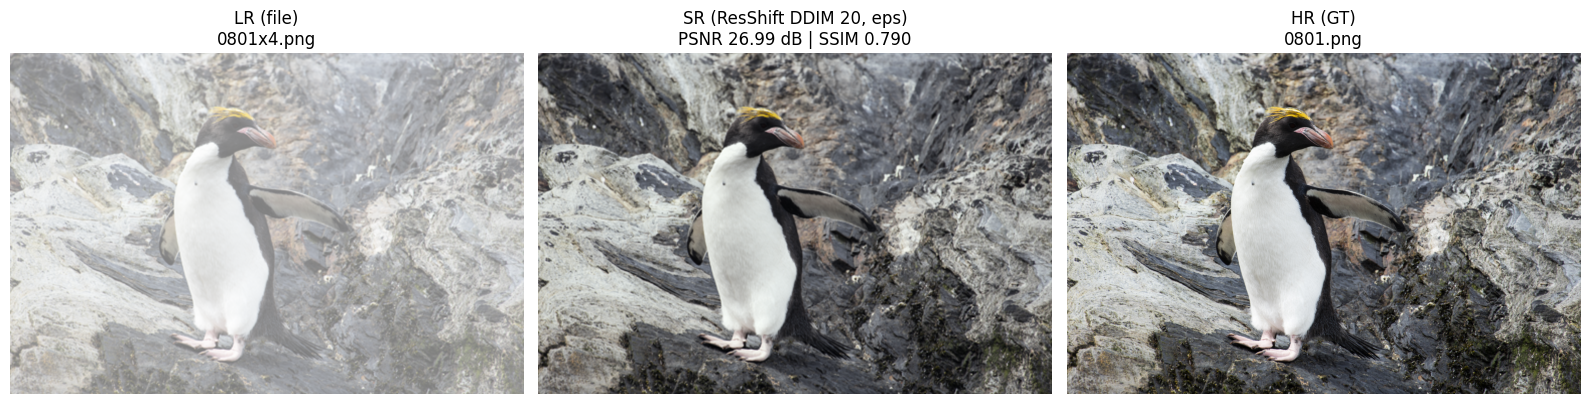

[Saved 0] eval_resshift_results22/000_LR.png | eval_resshift_results22/000_SR.png | eval_resshift_results22/000_HR.png | eval_resshift_results22/000_panel.png (chose eps, PSNR=26.99, SSIM=0.790)


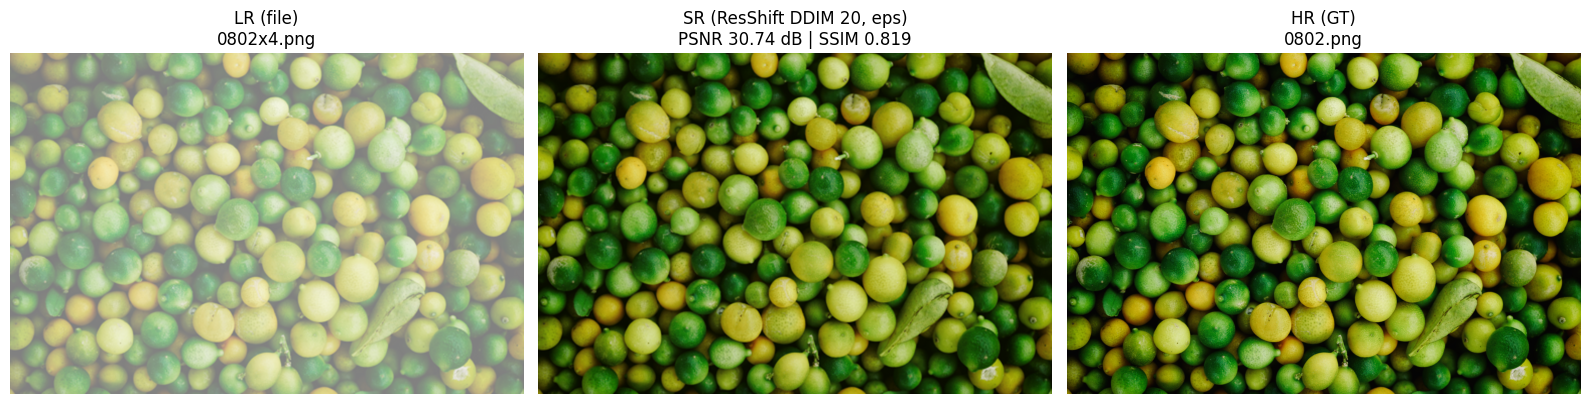

[Saved 1] eval_resshift_results22/001_LR.png | eval_resshift_results22/001_SR.png | eval_resshift_results22/001_HR.png | eval_resshift_results22/001_panel.png (chose eps, PSNR=30.74, SSIM=0.819)


In [ ]:
#  evaluating first 3 images
import os, re, math, shutil
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF
from PIL import Image
from skimage.metrics import peak_signal_noise_ratio as _psnr
from skimage.metrics import structural_similarity   as _ssim

WEIGHTS_PATH = "resdiff_model2.pth"
SCALE        = 4

HR_DIR = globals().get('VALID_HR_DIR', "DIV2K_valid_HR")
LR_DIR = globals().get('VALID_LR_DIR', r"DIV2K_valid_LR_bicubic_X4/DIV2K_valid_LR_bicubic/X4")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


if 'model' not in globals():
    if 'DiffusionUNet' in globals():
        model = DiffusionUNet(base_channels=64, time_dim=256, in_channels=6, out_channels=3)
    elif 'ResidualDiffusionUNet' in globals():
        model = ResidualDiffusionUNet(base_channels=64, time_dim=256, in_channels=6, out_channels=3)
    else:
        raise RuntimeError(
            "Model class not found. Run the cell that defines DiffusionUNet or ResidualDiffusionUNet first."
        )

model = model.to(device)
model_name = model.__class__.__name__

if not os.path.exists(WEIGHTS_PATH):
    raise FileNotFoundError(f"Couldn't find weights at '{WEIGHTS_PATH}'. Make sure you've saved them.")
try:
    sd = torch.load(WEIGHTS_PATH, map_location=device, weights_only=True)
except TypeError:
    sd = torch.load(WEIGHTS_PATH, map_location=device)

load_out = model.load_state_dict(sd, strict=False)
missing = getattr(load_out, "missing_keys", [])
unexpected = getattr(load_out, "unexpected_keys", [])
if missing or unexpected:
    print("[Warn] Non-strict load.")
    if missing:   print("  missing:", missing)
    if unexpected:print("  unexpected:", unexpected)

model.eval()
print(f"[Model] Loaded {model_name} weights from '{WEIGHTS_PATH}' on {device}.")

def _list_images_recursive(root):
    exts = (".png",".jpg",".jpeg",".bmp")
    out = []
    for r, _, files in os.walk(root):
        for f in files:
            if f.lower().endswith(exts):
                out.append(os.path.join(r, f))
    return out

def _nat_key(s):  # natural sort by number in filename
    return [int(t) if t.isdigit() else t.lower() for t in re.split(r'(\d+)', os.path.basename(s))]

def _index_lr(files, scale=4):
    idx = {}
    pat = re.compile(rf"^(.*?)[xX]{scale}$")
    for p in files:
        base = os.path.splitext(os.path.basename(p))[0]
        m = pat.match(base)
        if m:
            idx[m.group(1).lower()] = p
    return idx

hr_paths = _list_images_recursive(HR_DIR)
lr_paths = _list_images_recursive(LR_DIR)
if len(hr_paths)==0 or len(lr_paths)==0:
    raise RuntimeError(f"[Paths invalid]\n  HR={HR_DIR} (found {len(hr_paths)})\n  LR={LR_DIR} (found {len(lr_paths)})")

lr_index = _index_lr(lr_paths, scale=SCALE)
pairs = []
for hp in sorted(hr_paths, key=_nat_key):
    key = os.path.splitext(os.path.basename(hp))[0].lower()
    if key in lr_index:
        pairs.append((hp, lr_index[key]))

if not pairs:
    raise RuntimeError(f"No HR/LR pairs matched like 0001.png ↔ 0001x{SCALE}.png.\nHR={HR_DIR}\nLR={LR_DIR}")

print(f"[Paths]\n  HR: {HR_DIR}\n  LR: {LR_DIR}")
print(f"[Pairing] Matched {len(pairs)} HR/LR pairs.")
num_samples = min(3, len(pairs))
print(f"[Eval] Using first {num_samples} validation pairs.")

class _ValPairs(torch.utils.data.Dataset):
    def __init__(self, pairs): self.pairs = pairs
    def __len__(self): return len(self.pairs)
    def __getitem__(self, i):
        hp, lp = self.pairs[i]
        return TF.to_tensor(Image.open(hp).convert("RGB")), \
               TF.to_tensor(Image.open(lp).convert("RGB")), \
               os.path.basename(hp), os.path.basename(lp)

val_dataset_with_pairs = _ValPairs(pairs)

def _build_resshift_schedule(
    num_timesteps=50, min_eta=1e-4, max_eta=0.99, power=0.3, kappa_val=2.0, device=None
):
    etas = []
    for i in range(num_timesteps):
        t_norm = i / max(1, num_timesteps-1)
        eta = (min_eta ** (1-power)) * ((max_eta ** (1-power) - min_eta ** (1-power)) * t_norm + min_eta ** (1-power))
        etas.append(eta)
    etas = torch.tensor(etas, dtype=torch.float32, device=device)
    return etas, float(kappa_val)

if 'etas_tensor' in globals() and 'kappa' in globals():
    etas = etas_tensor.to(device)
    kappa_val = float(kappa)
else:
    num_timesteps = int(globals().get('num_timesteps', 50))
    etas, kappa_val = _build_resshift_schedule(num_timesteps=num_timesteps, device=device)

def _call_model(model, x, lr_up, t_tensor):

    try:
        return model(x, cond=lr_up, t=t_tensor)
    except TypeError:
        try:
            return model(x, t_tensor, lr_up)
        except TypeError:
            return model(x, lr_up, t_tensor)

@torch.no_grad()
def resshift_sr_from_lr(model, lr_img_01, steps=20, scale=4, pred_type="x0",
                        start_noise=0.01, deterministic=True):

    model.eval()
    H, W = lr_img_01.shape[1] * scale, lr_img_01.shape[2] * scale
    # Use BICUBIC upsampling to MATCH typical training condition (lr_up)
    lr_up_01 = TF.resize(lr_img_01, [H, W], interpolation=TF.InterpolationMode.BICUBIC).unsqueeze(0).to(device)
    lr_up = lr_up_01 * 2 - 1  # [-1,1]

    x = lr_up + start_noise * torch.randn_like(lr_up)
    steps = min(int(steps), int(etas.numel()))

    for t in range(steps-1, -1, -1):
        eta_t    = etas[t]
        eta_prev = etas[t-1] if t > 0 else torch.tensor(0.0, device=device)
        t_tensor = torch.full((x.size(0),), t, device=device, dtype=torch.long)

        if pred_type == "eps":
            eps = _call_model(model, x, lr_up, t_tensor)
            x0  = (x - eta_t * lr_up - kappa_val * torch.sqrt(torch.clamp(eta_t, min=1e-8)) * eps) / (1 - eta_t + 1e-8)
        else: 
            x0 = _call_model(model, x, lr_up, t_tensor).clamp(-1, 1)
            eps = (x - (1 - eta_t) * x0 - eta_t * lr_up) / (kappa_val * torch.sqrt(torch.clamp(eta_t, min=1e-8)))

        if t == 0:
            x = x0
        else:
            if deterministic:
                x = (1 - eta_prev) * x0 + eta_prev * lr_up + kappa_val * torch.sqrt(torch.clamp(eta_prev, min=0.0)) * eps
            else:
                x = (1 - eta_prev) * x0 + eta_prev * lr_up + kappa_val * torch.sqrt(torch.clamp(eta_prev, min=0.0)) * torch.randn_like(x)

    return ((x + 1) / 2).clamp(0, 1)


def _np_img(t):
    t = t.detach().cpu()
    if t.min() < 0: t = (t + 1) / 2
    return t.permute(1,2,0).clamp(0,1).numpy()

def _ssim_safe(a, b):
    try:   return _ssim(a, b, data_range=1.0, channel_axis=2)
    except TypeError: return _ssim(a, b, data_range=1.0, multichannel=True)


out_dir = "eval_resshift_results22"
os.makedirs(out_dir, exist_ok=True)

for i in range(num_samples):
    hr_01, lr_01, hr_name, lr_name = val_dataset_with_pairs[i]  # [3,H,W], [3,h,w] in [0,1]
    hr_01 = hr_01.to(device)
    lr_01 = lr_01.to(device)

    sr_x0  = resshift_sr_from_lr(model, lr_01, steps=20, scale=SCALE, pred_type="x0").squeeze(0)
    sr_eps = resshift_sr_from_lr(model, lr_01, steps=20, scale=SCALE, pred_type="eps").squeeze(0)

    H, W = hr_01.shape[1:]
    lr_up_01 = TF.resize(lr_01, [H, W], interpolation=TF.InterpolationMode.BICUBIC)

    hr_img = _np_img(hr_01)
    lr_img = _np_img(lr_up_01)
    x0_img = _np_img(sr_x0)
    eps_img= _np_img(sr_eps)

    psnr_x0 = _psnr(hr_img, x0_img, data_range=1.0)
    psnr_eps= _psnr(hr_img, eps_img, data_range=1.0)
    ssim_x0 = _ssim_safe(hr_img, x0_img)
    ssim_eps= _ssim_safe(hr_img, eps_img)

    if psnr_x0 >= psnr_eps:
        sr_img, psnr_val, ssim_val, chosen = x0_img, psnr_x0, ssim_x0, "x0"
        sr_torch = sr_x0
    else:
        sr_img, psnr_val, ssim_val, chosen = eps_img, psnr_eps, ssim_eps, "eps"
        sr_torch = sr_eps

    fig, axes = plt.subplots(1, 3, figsize=(16,5))
    axes[0].imshow(lr_img); axes[0].set_title(f"LR (file)\n{lr_name}"); axes[0].axis("off")
    axes[1].imshow(sr_img); axes[1].set_title(f"SR (ResShift DDIM 20, {chosen})\nPSNR {psnr_val:.2f} dB | SSIM {ssim_val:.3f}"); axes[1].axis("off")
    axes[2].imshow(hr_img); axes[2].set_title(f"HR (GT)\n{hr_name}"); axes[2].axis("off")
    plt.tight_layout(); plt.show()

    TF.to_pil_image(lr_01).save(f"{out_dir}/{i:03d}_LR.png")
    TF.to_pil_image(sr_torch).save(f"{out_dir}/{i:03d}_SR.png")
    TF.to_pil_image(hr_01).save(f"{out_dir}/{i:03d}_HR.png")
    fig.savefig(f"{out_dir}/{i:03d}_panel.png", dpi=150)
    plt.close(fig)

    print(f"[Saved {i}] {out_dir}/{i:03d}_LR.png | {out_dir}/{i:03d}_SR.png | {out_dir}/{i:03d}_HR.png | {out_dir}/{i:03d}_panel.png "
          f"(chose {chosen}, PSNR={psnr_val:.2f}, SSIM={ssim_val:.3f})")

zip_path = shutil.make_archive(out_dir, "zip", out_dir)
print(f"\nZIP ready → {zip_path}")
